# About : Welding Process Optimization using AI model
## Author : Jin Kwak/21900031
## Created : 24.06.02
## 중소벤처기업부, Korea AI Manufacturing Platform(KAMP), 용접 공정최적화 AI 데이터셋, 스마트제조혁신추진단(㈜인터엑스), 2022.12.23., www.kamp-ai.kr
## [Click here for Reference](https://www.kamp-ai.kr/main) 
## [Click here for Dataset](https://www.kamp-ai.kr/aidataDetail?DATASET_SEQ=52&page=1)

## **Algorithm List**
1. Decision Tree
2. XGBoost
3. LightGBM

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import scipy.stats
from scipy.stats import ttest_1samp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_score, recall_score,mean_squared_error
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_csv('data/용접 데이터.csv')
df
df['PIPE_NO'].value_counts()

PIPE_NO
PP22010600041    7922
PP22010600043    6684
PP21110400199    6508
PP21110400198    6450
PP21110900020    6230
                 ... 
PP22011200021      90
PP22022500076      68
PP22033000042      68
PP22011000045      34
PP21110100008      24
Name: count, Length: 303, dtype: int64

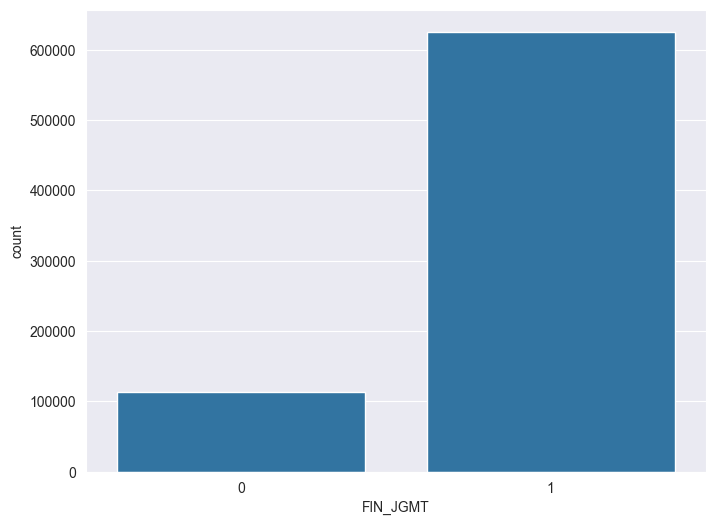

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.countplot(x = 'FIN_JGMT', data = df)
plt.show()

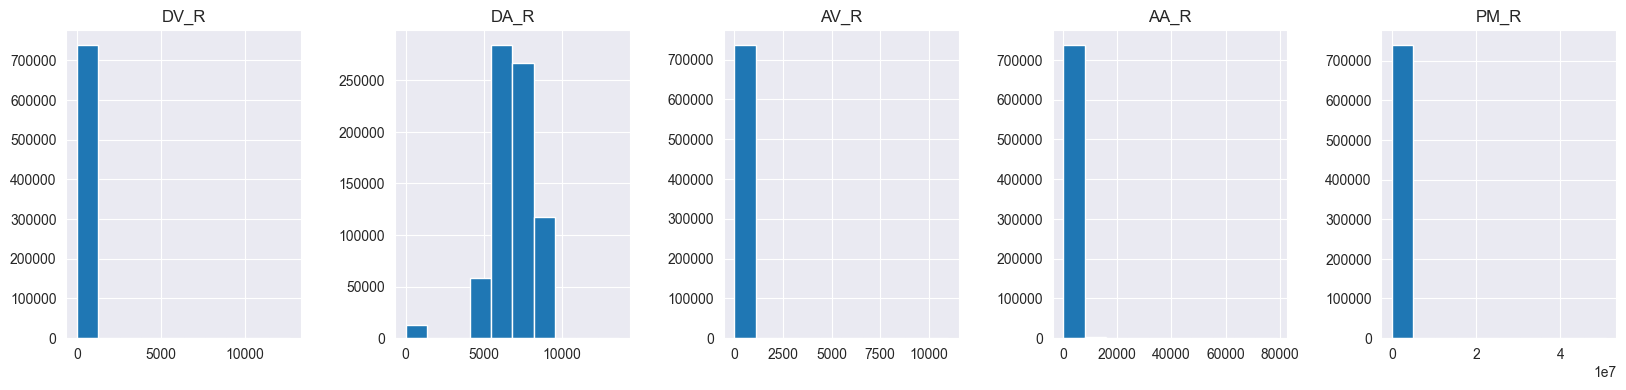

In [17]:
#공정변수 시각화
vars_list = ['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R']
plt.figure(figsize=(20, 4))
for i, col in enumerate(vars_list):
 plt.subplot(1, 5, i+1)
 n, bins, patches = plt.hist(df[col], bins=10)
 plt.title(col)
 plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [18]:
pass_product = len(df[df['FIN_JGMT']==1])
fail_product = len(df[df['FIN_JGMT']==0])
print('양품 수 : ', pass_product)
print('불량품 수 : ', fail_product)
print('불량품 발생률 : ''%.2f' %(fail_product / (pass_product + fail_product) * 100))

양품 수 :  626092
불량품 수 :  113796
불량품 발생률 : 15.38


In [19]:
df.isnull().sum()

PIPE_NO     0
DV_R        0
DA_R        0
AV_R        0
AA_R        0
PM_R        0
FIN_JGMT    0
dtype: int64

In [20]:
df = df.copy()
df

,PIPE_NO,DV_R,DA_R,AV_R,AA_R,PM_R,FIN_JGMT
0,PP22033000042,318,7798,365,7177,9507,1
1,PP22033000042,318,7798,365,7177,9507,1
2,PP22033000042,316,8479,380,8846,9484,1
3,PP22033000042,316,8479,380,8846,9484,1
4,PP22033000042,309,7603,351,5726,9840,1
...,...,...,...,...,...,...,...
739883,PP22032100113,321,6079,352,5857,9629,1
739884,PP22032100113,313,6917,360,6185,9417,1
739885,PP22032100113,313,6917,360,6185,9417,1
739886,PP22032100113,311,6262,343,5919,9632,1


### Step 3. Brief Data Characteristics analysis

In [21]:
df.columns
df.shape

(739888, 7)

In [28]:
df.describe()


,DV_R,DA_R,AV_R,AA_R,PM_R,FIN_JGMT
count,739888.000000,739888.000000,739888.000000,739888.000000,739888.000000,739888.000000
mean,312.071238,6963.618199,347.380109,5811.588532,9415.033583,0.846198
std,6.003667,1058.582689,11.219950,385.120100,864.243293,0.360759
min,299.000000,5072.000000,311.000000,5008.000000,6422.000000,0.000000
25%,309.000000,6156.000000,341.000000,5631.000000,9285.000000,1.000000
50%,310.000000,6979.000000,349.000000,5818.000000,9569.000000,1.000000
75%,316.000000,7857.000000,354.000000,5993.000000,9832.000000,1.000000
max,330.000000,8630.000000,365.000000,7051.000000,10718.000000,1.000000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739888 entries, 0 to 739887
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   PIPE_NO   739888 non-null  object
 1   DV_R      739888 non-null  int64 
 2   DA_R      739888 non-null  int64 
 3   AV_R      739888 non-null  int64 
 4   AA_R      739888 non-null  int64 
 5   PM_R      739888 non-null  int64 
 6   FIN_JGMT  739888 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 39.5+ MB


In [30]:
df.isnull().sum()


PIPE_NO     0
DV_R        0
DA_R        0
AV_R        0
AA_R        0
PM_R        0
FIN_JGMT    0
dtype: int64

In [31]:
df.fillna(0, inplace=True)

In [32]:
for col in vars_list:
 upper_bound = np.percentile(df[col], [98])[0]
 lower_bound = np.percentile(df[col], [2])[0]
 df.loc[df[col] > upper_bound, col] = upper_bound
 df.loc[df[col] < lower_bound, col] = lower_bound

In [33]:
df_corr = df.drop('PIPE_NO', axis= 1).corr()
pd.DataFrame(df_corr['FIN_JGMT'].sort_values())

,FIN_JGMT
DA_R,0.007113
AA_R,0.017764
DV_R,0.050036
PM_R,0.071701
AV_R,0.208610
FIN_JGMT,1.000000


In [34]:
vars_list = ['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R']
cols = ['FIN_JGMT', 'DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R']
        
dat_0 = df.loc[df['FIN_JGMT'] == 0][cols]
dat_1 = df.loc[df['FIN_JGMT'] == 1][cols]
scipy.stats.ttest_ind(dat_0, dat_1, equal_var=False)

Ttest_indResult(statistic=array([         -inf,  -36.6956246 ,   -6.42010474, -142.31673999,
        -17.66245386,  -64.10311096]), pvalue=array([0.00000000e+000, 2.11099551e-293, 1.36548469e-010, 0.00000000e+000,
       9.32822016e-070, 0.00000000e+000]))

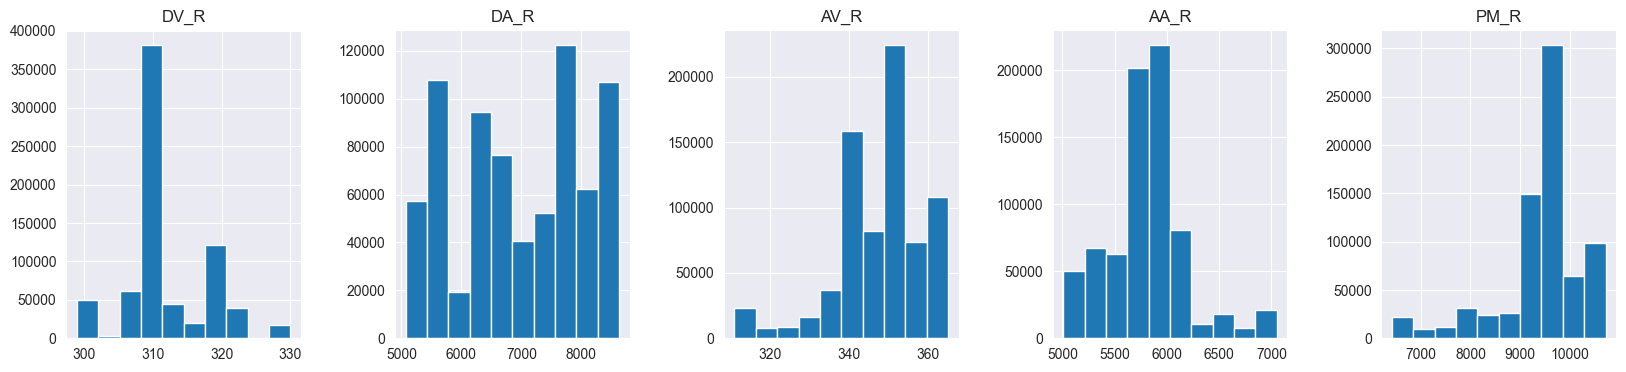

In [35]:
#공정변수 시각화
vars_list = ['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R']
plt.figure(figsize=(20, 4))
for i, col in enumerate(vars_list):
 plt.subplot(1, 5, i+1)
 n, bins, patches = plt.hist(df[col], bins=10)
 plt.title(col)
 plt.subplots_adjust(wspace=0.4, hspace=0.4)

6.0 0.0


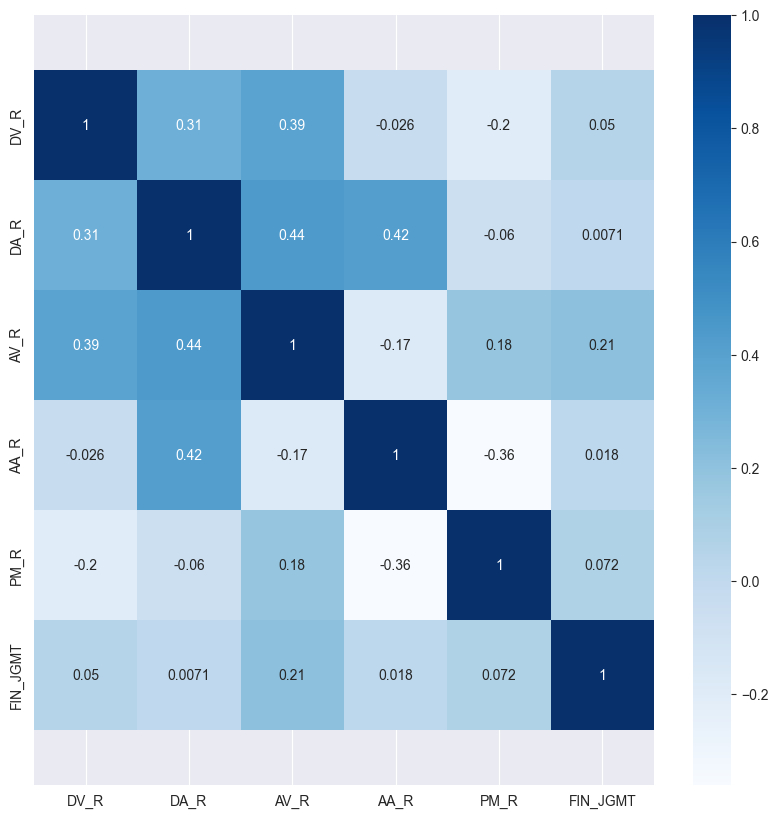

In [27]:
fig = plt.figure(figsize = (10, 10))
fig.set_facecolor('white')
ax = sns.heatmap(df_corr, annot=True, cmap='Blues')
bottom, top = ax.get_ylim()
print(bottom, top)
ax.set_ylim(bottom+0.5, top-0.5)
plt.show()

In [36]:
X = df[vars_list]
y = df['FIN_JGMT']
y

0         1
1         1
2         1
3         1
4         1
         ..
739883    1
739884    1
739885    1
739886    1
739887    1
Name: FIN_JGMT, Length: 739888, dtype: int64

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [38]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(517921, 5)
(221967, 5)
(517921,)
(221967,)


In [40]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
from sklearn.tree import DecisionTreeClassifier
kfold = KFold(n_splits=3, shuffle=True)
dt_kf_acc = []
dt = DecisionTreeClassifier(random_state=42)
n_iter = 0
for train_idx, valid_idx in kfold.split(X_train):
 X_train_, X_valid_ = X_train[train_idx], X_train[valid_idx]
 y_train_, y_valid_ = y_train[train_idx], y_train[valid_idx]
 # DecisionTreeClassifier 훈련
 dt.fit(X_train_, y_train_)
 dt_pred = dt.predict(X_valid_)
 dt_acc = accuracy_score(dt_pred, y_valid_)
 n_iter += 1
 dt_kf_acc.append([n_iter, dt_acc, dt])
 print(f'KFold {n_iter} 교차검증 정확도 : {dt_acc}, 학습 데이터 크기:{X_train_.shape[0]}, 검증 데이터 크기:{X_valid_.shape[0]}')
dt_kf_acc.sort(key=lambda x : x[1], reverse=True)
# KFold 검증 후 가장 정확도가 높은 모델 선택
dt = dt_kf_acc[0][2]
print(f'교차검증 중 가장 높은 정확도 : KFold {dt_kf_acc[0][0]}, {dt_kf_acc[0][1]}')

KFold 1 교차검증 정확도 : 0.9581559420995013, 학습 데이터 크기:345280, 검증 데이터 크기:172641
KFold 2 교차검증 정확도 : 0.9589029193697869, 학습 데이터 크기:345281, 검증 데이터 크기:172640
KFold 3 교차검증 정확도 : 0.9582947173308619, 학습 데이터 크기:345281, 검증 데이터 크기:172640
교차검증 중 가장 높은 정확도 : KFold 2, 0.9589029193697869


In [43]:
from xgboost import XGBClassifier
kfold = KFold(n_splits=3, shuffle=True)
xgb_kf_acc = []
xgb = XGBClassifier(random_state=42)
n_iter = 0
for train_idx, valid_idx in kfold.split(X_train):
 X_train_, X_valid_ = X_train[train_idx], X_train[valid_idx]
 y_train_, y_valid_ = y_train[train_idx], y_train[valid_idx]
 # XGBoostClassifier 훈련
 xgb.fit(X_train_, y_train_)
 xgb_pred = xgb.predict(X_valid_)
 xgb_acc = accuracy_score(xgb_pred, y_valid_)
 n_iter += 1
 xgb_kf_acc.append([n_iter, xgb_acc, xgb])
 print(f'KFold {n_iter} 교차검증 정확도 : {xgb_acc}, 학습 데이터 크기:{X_train_.shape[0]}, 검증 데이터 크기:{X_valid_.shape[0]}')
xgb_kf_acc.sort(key=lambda x : x[1], reverse=True)
# KFold 검증 후 가장 정확도가 높은 모델 선택
xgb = xgb_kf_acc[0][2]
print(f'교차검증 중 가장 높은 정확도 : KFold {xgb_kf_acc[0][0]}, {xgb_kf_acc[0][1]}')

KFold 1 교차검증 정확도 : 0.9493573369014313, 학습 데이터 크기:345280, 검증 데이터 크기:172641
KFold 2 교차검증 정확도 : 0.9499478683966636, 학습 데이터 크기:345281, 검증 데이터 크기:172640
KFold 3 교차검증 정확도 : 0.9488531047265987, 학습 데이터 크기:345281, 검증 데이터 크기:172640
교차검증 중 가장 높은 정확도 : KFold 2, 0.9499478683966636


In [44]:
from lightgbm import LGBMClassifier
kfold = KFold(n_splits=3, shuffle=True)
lgbm_kf_acc = []
lgbm = LGBMClassifier(random_state=42)
n_iter = 0
for train_idx, valid_idx in kfold.split(X_train):
 X_train_, X_valid_ = X_train[train_idx], X_train[valid_idx]
 y_train_, y_valid_ = y_train[train_idx], y_train[valid_idx]
 # LGBMClassifier 훈련
 lgbm.fit(X_train_, y_train_)
 lgbm_pred = lgbm.predict(X_valid_)
 lgbm_acc = accuracy_score(lgbm_pred, y_valid_)
 n_iter += 1
 lgbm_kf_acc.append([n_iter, lgbm_acc, lgbm])
 print(f'KFold {n_iter} 교차검증 정확도 : {lgbm_acc}, 학습 데이터 크기:{X_train_.shape[0]}, 검증 데이터 크기:{X_valid_.shape[0]}')
lgbm_kf_acc.sort(key=lambda x : x[1], reverse=True)
# KFold 검증 후 가장 정확도가 높은 모델 선택
lgbm = lgbm_kf_acc[0][2]
print(f'교차검증 중 가장 높은 정확도 : KFold {lgbm_kf_acc[0][0]}, {lgbm_kf_acc[0][1]}')

[LightGBM] [Info] Number of positive: 291886, number of negative: 53394
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 345280, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.845360 -> initscore=1.698665
[LightGBM] [Info] Start training from score 1.698665
KFold 1 교차검증 정확도 : 0.9474168940170643, 학습 데이터 크기:345280, 검증 데이터 크기:172641
[LightGBM] [Info] Number of positive: 292234, number of negative: 53047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points

DecisionTreeClassifier(random_state=42)
precision: 0.977321756589346 recall: 0.9733353187370705
F1-Score: 0.9753244642443201 Accuracy: 0.9582775818027004
2.0 0.0


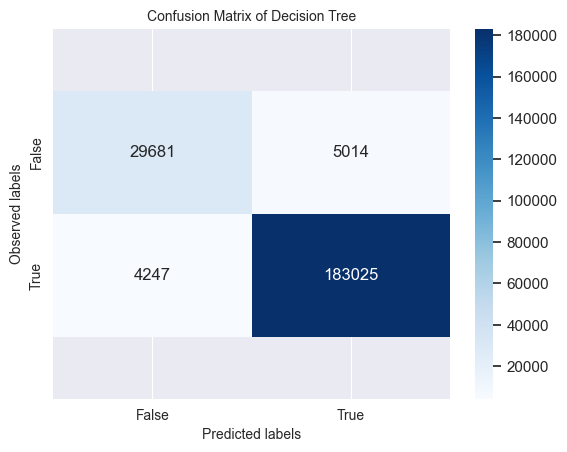

In [45]:
# 테스트셋으로 모델 테스트
dt_pred = dt.predict(X_test)
dt_pred = np.choose(dt_pred, [0, 1]).astype(float)
result = {}
# 테스트 정확도 출력
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_acc = accuracy_score(dt_pred, y_test)
dt_cm = confusion_matrix(dt_pred, y_test)
result['DecisionTree'] = {'precision':dt_precision, 'recall':dt_recall, 'f1-score':dt_f1, 'accuracy':dt_acc}
print(f'{dt}\nprecision: {dt_precision} recall: {dt_recall}\nF1-Score: {dt_f1} Accuracy: {dt_acc}')
# 오차행렬 시각화
ax = plt.subplot()
sns.set(font_scale=1.0)
sns.heatmap(dt_cm, annot=True, ax=ax, cmap="Blues", fmt="g");
label_font = {'size':'10'}
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
title_font = {'size':'10'}
ax.set_title('Confusion Matrix of Decision Tree', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_ticklabels(['False', 'True']);
ax.yaxis.set_ticklabels(['False', 'True']);
bottom, top = ax.get_ylim()
print(bottom, top)
ax.set_ylim(bottom+0.5, top-0.5)
plt.show()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
precision: 0.9575598051484657 recall: 0.9847478448619701
F1-Score: 0.9709635385942421 Accuracy: 0.9501051958173963
2.0 0.0


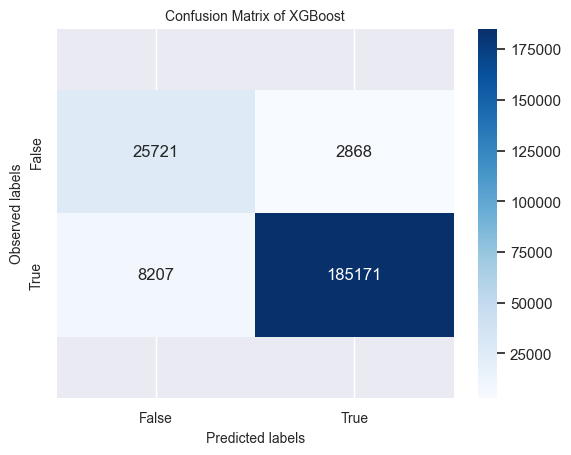

In [46]:
xgb_pred = xgb.predict(X_test)
xgb_pred = np.choose(xgb_pred, [0, 1]).astype(float)
result = {}
# 테스트 정확도 출력
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_acc = accuracy_score(xgb_pred, y_test)
xgb_cm = confusion_matrix(xgb_pred, y_test)
result['XGBoost'] = {'precision':xgb_precision, 'recall':xgb_recall, 'f1-score':xgb_f1, 'accuracy':xgb_acc}
print(f'{xgb}\nprecision: {xgb_precision} recall: {xgb_recall}\nF1-Score: {xgb_f1} Accuracy: {xgb_acc}')
# 오차행렬 시각화
ax = plt.subplot()
sns.set(font_scale=1.0)
sns.heatmap(xgb_cm, annot=True, ax=ax, cmap="Blues", fmt="g");
label_font = {'size':'10'}
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
title_font = {'size':'10'}
ax.set_title('Confusion Matrix of XGBoost', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_ticklabels(['False', 'True']);
ax.yaxis.set_ticklabels(['False', 'True']);
bottom, top = ax.get_ylim()
print(bottom, top)
ax.set_ylim(bottom+0.5, top-0.5)
plt.show()

LGBMClassifier(random_state=42)
precision: 0.9519938116022213 recall: 0.9882683911316269
F1-Score: 0.9697920118567072 Accuracy: 0.9478435983727311
2.0 0.0


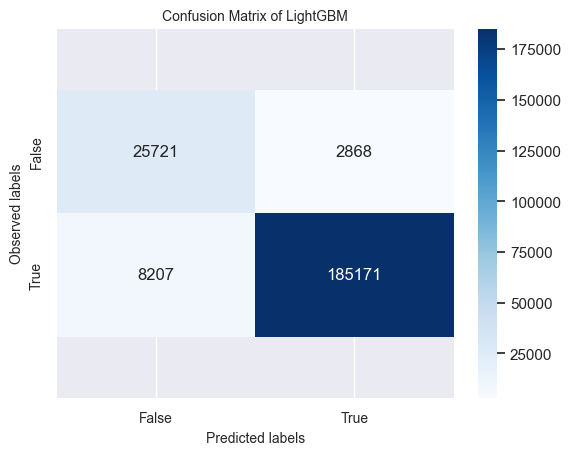

In [47]:
# 테스트셋으로 모델 테스트
lgbm_pred = lgbm.predict(X_test)
lgbm_pred = np.choose(lgbm_pred, [0, 1]).astype(float)
result = {}
# 테스트 정확도 출력
lgbm_precision = precision_score(y_test, lgbm_pred)
lgbm_recall = recall_score(y_test, lgbm_pred)
lgbm_f1 = f1_score(y_test, lgbm_pred)
lgbm_acc = accuracy_score(lgbm_pred, y_test)
lgbm_cm = confusion_matrix(lgbm_pred, y_test)
result['LightGBM'] = {'precision':lgbm_precision, 'recall':lgbm_recall, 'f1-score':lgbm_f1, 'accuracy':lgbm_acc}
print(f'{lgbm}\nprecision: {lgbm_precision} recall: {lgbm_recall}\nF1-Score: {lgbm_f1} Accuracy: {lgbm_acc}')
# 오차행렬 시각화
ax = plt.subplot()
sns.set(font_scale=1.0)
sns.heatmap(xgb_cm, annot=True, ax=ax, cmap="Blues", fmt="g");
label_font = {'size':'10'}
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
title_font = {'size':'10'}
ax.set_title('Confusion Matrix of LightGBM', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_ticklabels(['False', 'True']);
ax.yaxis.set_ticklabels(['False', 'True']);
bottom, top = ax.get_ylim()
print(bottom, top)
ax.set_ylim(bottom+0.5, top-0.5)
plt.show()

In [48]:
print('테스트셋 정확도\n')
print('dt : ',accuracy_score(y_test, dt_pred))
print('xgb : ',accuracy_score(y_test, xgb_pred))
print('lgbm : ',accuracy_score(y_test, lgbm_pred))

테스트셋 정확도

dt :  0.9582775818027004
xgb :  0.9501051958173963
lgbm :  0.9478435983727311


PM_R    0.528090
DA_R    0.179541
AV_R    0.134889
AA_R    0.109692
DV_R    0.047788
dtype: float64


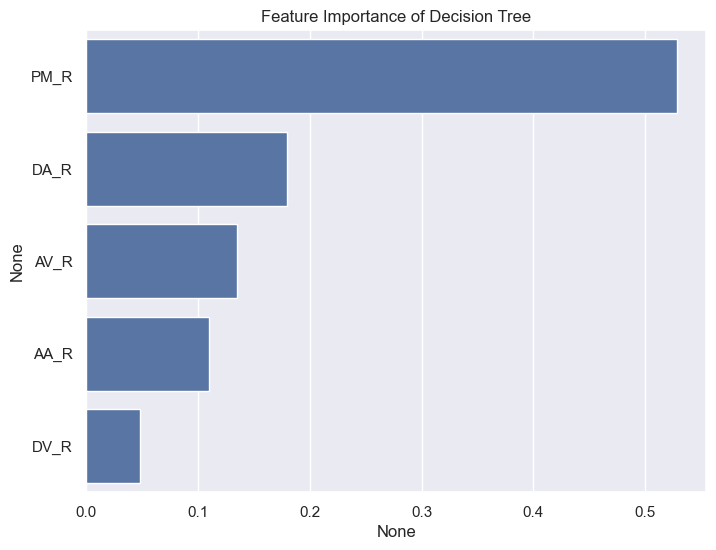

In [49]:
# plt.barh(df[vars_list].columns, dt.feature_importances_)
feature_importances = pd.Series(dt.feature_importances_, index = df[vars_list].columns)
feature_top5 = feature_importances.sort_values(ascending=False)
print(feature_top5)
plt.figure(figsize=(8,6))
plt.title('Feature Importance of Decision Tree')
sns.barplot(x = feature_top5, y = feature_top5.index)
plt.show()

In [50]:
X_train_scaled_inverse = scaler.inverse_transform(X_train_scaled)
X_test_scaled_inverse = scaler.inverse_transform(X_test_scaled)

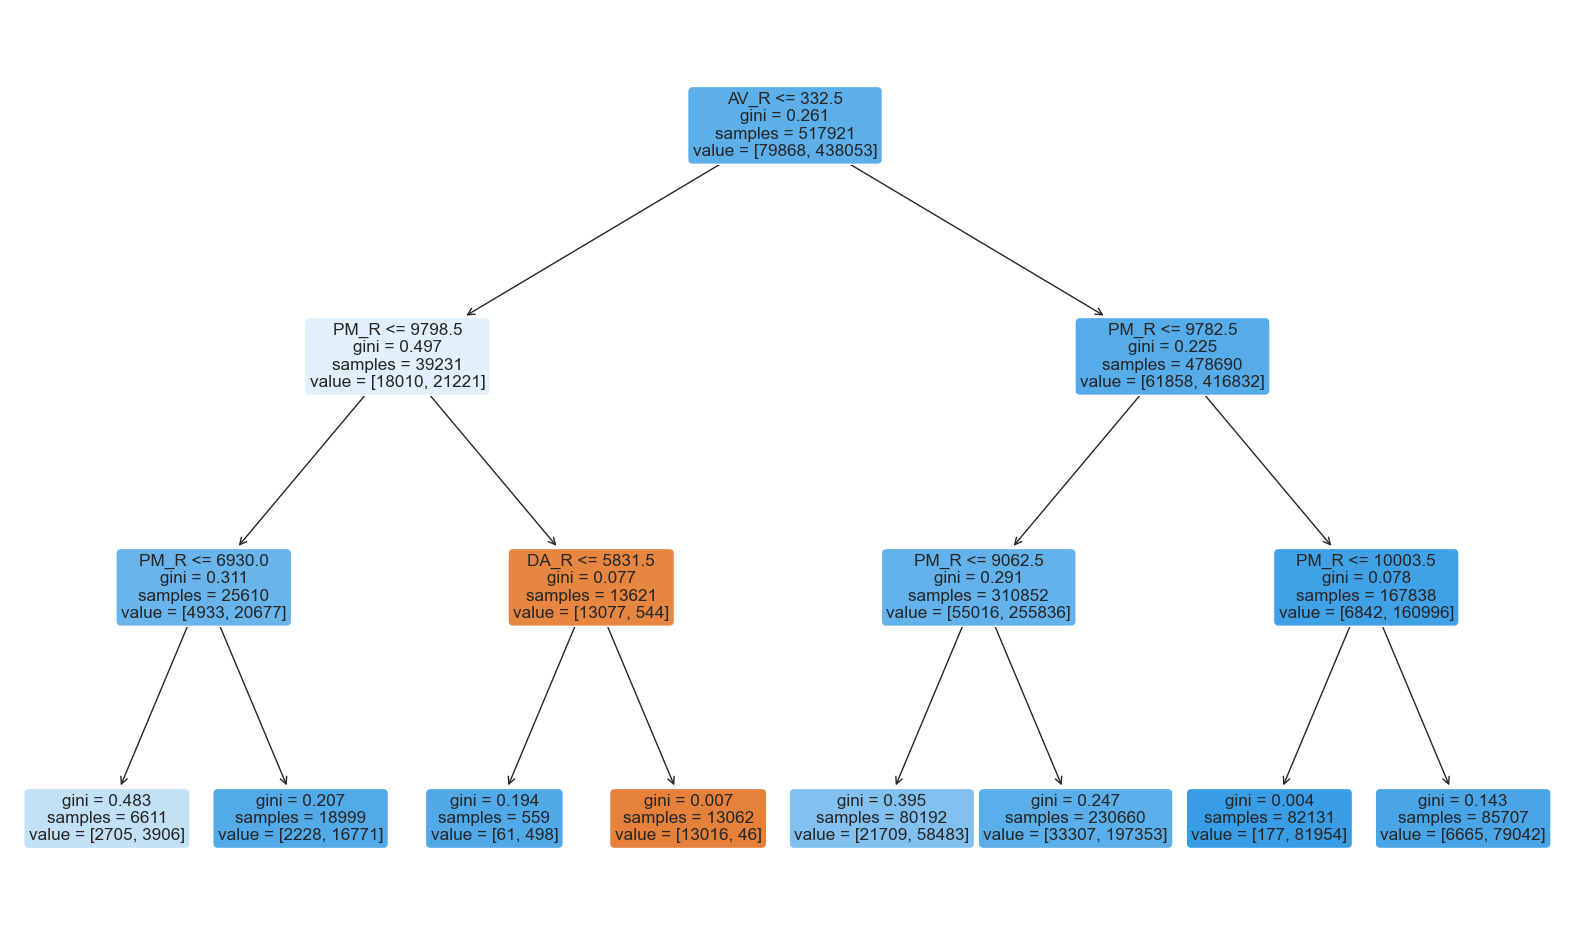

In [51]:
# DecisionTreeClassifier 정의
dt_clf = DecisionTreeClassifier(random_state=42, max_depth=3)
# DecisionTreeClassifier 훈련
dt_clf.fit(X_train_scaled_inverse, y_train)
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize = (20,12))
tree.plot_tree(dt_clf, feature_names=df[vars_list].columns, impurity=True, filled=True, rounded=True);

In [52]:
### 양품 집단과 불량 집단을 각각 ok와 ng로 정의 후, 공정변수 데이터 채택
ok = df[df['FIN_JGMT']==1]
ng = df[df['FIN_JGMT']==0]
OK = ok[vars_list]
NG = ng[vars_list]

<Axes: xlabel='PM_R', ylabel='Density'>

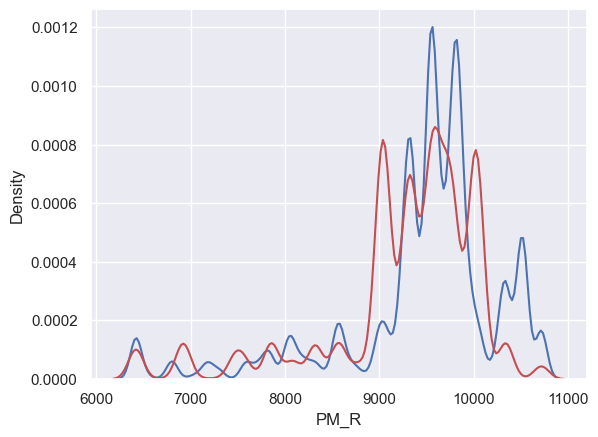

In [53]:
sns.kdeplot(data=OK[vars_list], x = "PM_R", color='b')
sns.kdeplot(data=NG[vars_list], x = "PM_R", color='r')

<Axes: xlabel='AV_R', ylabel='Density'>

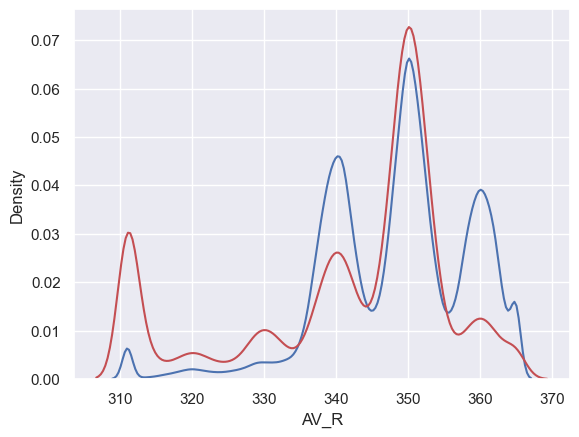

In [54]:
sns.kdeplot(data=OK[vars_list], x = "AV_R", color='b')
sns.kdeplot(data=NG[vars_list], x = "AV_R", color='r')